In [200]:
import pandas as pd
import numpy as np
import plotly.express as px
from lib.DrugUtil import flatten, DrugUtil
import matplotlib.pyplot as plt
import os

import plotly.express as px
from lib.FhirDataUtil import FhirDataUtil
from lib.CCSDataUtil import CCSDataUtil
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters

def printmd(string):
    display(string)

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

_fhir_conditions_file = "input/fhir_20230423/fhir_conditions.csv" # fhir_20221003
_fhir_medications_file = "input/fhir_20230423/fhir_medications.csv"
_fhir_medications_ref_file = "input/fhir_20230423/fhir_medications_references.csv"
_fhir_demographics_file = "input/fhir_20230423/fhir_demographics.csv"
_output_dir = 'output/'

_rxnorm_file = "input_static/RxTerms202203/RxTerms202203.txt"
_rxnorm_ingredients_file = "input_static/RxTerms202203/RxTermsIngredients202203.txt"
_rxclass_file = "input_static/_rxclass_2022-04-10.csv"

_ccs_demographics_file = "input/ccs_demographics.csv"
_ccs_medications_file = "input/ccs_medications.csv"
_ccs_conditions_file = "input/ccs_conditions.csv"

_pc_demographics_file = "input/pcornet2/demographic_fhir.csv"
_pc_medications_file = "input/pcornet2/med_adm_fhir.csv"
_pc_conditions_file = "input/pcornet2/diagnosis_fhir_v2.csv"
_pc_conditions_exclusions_file = "input/pcornet2/excluded_codes.xlsx"

# Chart Review
_cr_file = "input/chart_review/Chart_Review1.2c.xlsx"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
drugUtil = DrugUtil()
drugUtil.load(rxnorm_file=_rxnorm_file,
                        rxnorm_ingredients_file=_rxnorm_ingredients_file, 
                        rxclass_file=_rxclass_file)

fhirUtil = FhirDataUtil()
ccsUtil = CCSDataUtil(drugUtil)

fhirUtil.load_conditions(fhir_conditions_file=_fhir_conditions_file, remove_health_concerns=True)
fhirUtil.load_demographics(fhir_demographics_file=_fhir_demographics_file)
snomed = fhirUtil.conditions[fhirUtil.conditions['coding_system'] == 'SNOMED']
print(f'Number of snomeds: {len(snomed)}')
icd10 = fhirUtil.conditions[fhirUtil.conditions['coding_system'] == 'ICD10']
print(f'Number of ICD10s: {len(icd10)}')

ccsUtil.load_conditions(ccs_conditions_file= _ccs_conditions_file)
ccsUtil.load_demographics(_ccs_demographics_file)


fhir_cond = icd10
fhir_demo = fhirUtil.demographics
ccs_cond = ccsUtil.conditions
ccs_demo = ccsUtil.demographics

Reading rxclass file...
Reading rxnorm file...
RAW FHIR conditions: 74880
FHIR conditions after pre-processing: 52030
Number of snomeds: 27702
Number of ICD10s: 24328


/app/lib/CCSDataUtil.py:13: DtypeWarning: Columns (5,6,11,12,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.conditions = pd.read_csv(ccs_conditions_file, delimiter=',')
/app/lib/CCSDataUtil.py:75: DtypeWarning: Columns (11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  self.demographics = pd.read_csv(ccs_demographics)


Loaded CCS conditions records: 94735
Loaded demographics file with entries:  98877


In [69]:
# Load PCORnet conditions

pc_cond = pd.read_csv(_pc_conditions_file, low_memory=False)
print('PCORNet Conditions: ', len(pc_cond))
pc_cond['dx_date_d'] = pd.to_datetime(pc_cond['dx_date'], format="%d%b%Y", errors="coerce").fillna(pd.to_datetime(pc_cond['admit_date'], format="%d%b%Y", errors="coerce"))
# fhir_enc_raw['start_d'] = pd.to_datetime(fhir_enc_raw['start'], format="%Y-%m-%dT%H:%M:%SZ", errors="coerce").fillna(pd.to_datetime(fhir_enc_raw['start'], format="%Y-%m-%d", errors="coerce"))
pc_demo = pd.read_csv(_pc_demographics_file, low_memory=False)

site_config = {
    'UCSFHEALTHPARTN': 'openepic_shared_ucsf_health',
    'UT1PARTNER': 'openepic_shared_university_of_utah_healthcare',
    'NY1PARTNER': 'openepic_shared_nyu_langone_medical_center',
    'SH2PARTNER': 'openepic_shared_sutter_health',
    'OS2PARTNER': 'openepic_shared_ochsner_health_system',
    'MF1PARTNER': 'openepic_shared_montefiore_medical_center',
    'BA1PARTNER': 'openepic_shared_baylor_scott_white'
}
pc_cond['site'] = pc_cond['siteid']
pc_cond = pc_cond.replace({'site': site_config})

xls = pd.ExcelFile(_pc_conditions_exclusions_file)
pc_cond_excl = pd.read_excel(xls, 'exclusions')
pc_cond_excl = pc_cond_excl[pc_cond_excl['CODETYPE'] == 'DX10']
print('exclusions:', len(pc_cond_excl))

PCORNet Conditions:  114244
exclusions: 1006


In [99]:
# Load Chart Review data

xls = pd.ExcelFile(_cr_file)
cr_cond_raw = pd.read_excel(xls, 'Diagnostic Codes')
cr_demo = pd.read_excel(xls, 'users_to_query')
cr_cond_raw['date_entered_d'] = pd.to_datetime(cr_cond_raw['date_entered'], errors='coerce')
cr_cond_raw['diagnostic_code'] = cr_cond_raw['diagnostic_code'].str.strip()
cr_cond = cr_cond_raw.copy()

/usr/local/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning:

Data Validation extension is not supported and will be removed



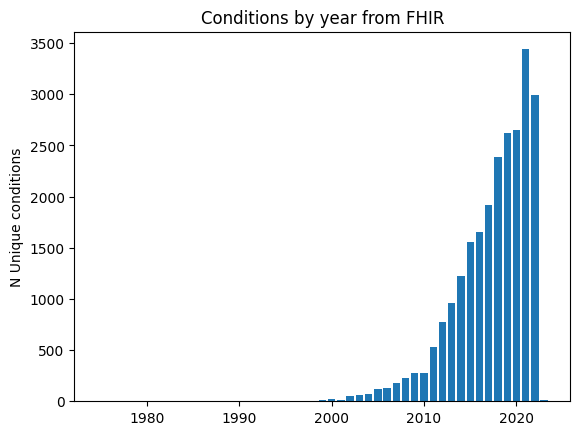

14553   1975-01-01
41232   1989-01-01
14526   1990-01-01
14527   1990-01-01
19315   1992-12-02
           ...    
35954   2023-01-04
57919   2023-01-04
57865   2023-01-04
50919   2023-01-04
50914   2023-01-04
Name: recordeddate_d, Length: 24170, dtype: datetime64[ns]

In [100]:
years = fhir_cond['recordeddate_d'].dt.year.value_counts().reset_index(name="Conditions")
plt.bar(years['index'], years['Conditions'])
plt.title('Conditions by year from FHIR')
plt.ylabel('N Unique conditions')
plt.show()
fhir_cond['recordeddate_d'].dropna().sort_values()


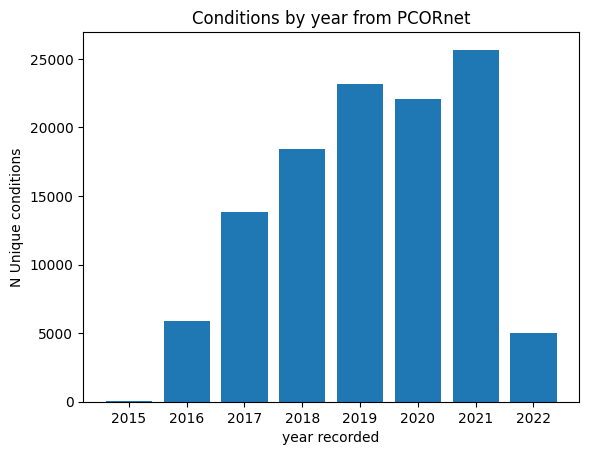

43809   2015-11-27
52418   2015-11-30
52428   2015-11-30
52421   2015-11-30
52417   2015-11-30
           ...    
67610   2022-04-07
67603   2022-04-07
1192    2022-04-08
1196    2022-04-08
91352   2022-04-09
Name: dx_date_d, Length: 114244, dtype: datetime64[ns]

In [101]:
years = pc_cond['dx_date_d'].dt.year.value_counts().reset_index(name="Conditions")
plt.bar(years['index'], years['Conditions'])
plt.title('Conditions by year from PCORnet')
plt.ylabel('N Unique conditions')
plt.xlabel('year recorded')
plt.show()
pc_cond['dx_date_d'].dropna().sort_values()



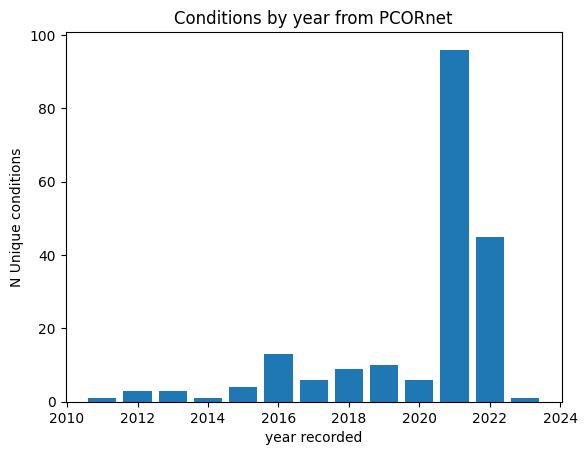

279   2011-06-07
276   2012-01-24
281   2012-01-24
205   2012-10-04
76    2013-04-08
187   2013-08-05
186   2013-08-05
188   2014-03-13
7     2015-02-03
8     2015-02-03
9     2015-02-03
14    2015-03-26
256   2016-01-13
259   2016-01-13
206   2016-01-20
255   2016-02-01
290   2016-02-01
278   2016-02-01
0     2016-03-27
1     2016-03-27
264   2016-05-03
268   2016-05-03
241   2016-05-03
240   2016-05-03
265   2016-05-09
111   2017-03-07
112   2017-03-29
113   2017-04-18
266   2017-06-05
114   2017-06-20
175   2017-09-22
11    2018-03-07
12    2018-03-07
13    2018-03-07
3     2018-04-06
2     2018-04-06
154   2018-06-05
153   2018-06-05
152   2018-06-05
271   2018-09-05
15    2019-02-04
41    2019-03-12
40    2019-03-12
37    2019-03-12
44    2019-03-12
38    2019-03-12
39    2019-05-07
222   2019-09-09
79    2019-12-10
78    2019-12-10
119   2020-03-03
118   2020-03-03
80    2020-03-31
77    2020-03-31
200   2020-05-21
201   2020-05-21
127   2021-01-01
129   2021-02-01
93    2021-02-

In [102]:
years = cr_cond['date_entered_d'].dt.year.value_counts().reset_index(name="Conditions")
plt.bar(years['index'], years['Conditions'])
plt.title('Conditions by year from PCORnet')
plt.ylabel('N Unique conditions')
plt.xlabel('year recorded')
plt.show()
cr_cond['date_entered_d'].dropna().sort_values()

# FILTER DATES to create _d

In [144]:
# Trim all data to the data pipeline date range (FHIR restriction)
start_date = '2015-11-27' # datetime.date(2015,11,27)
end_date = '2022-04-09'

cr_cond = cr_cond_raw.copy()

print(f'Filtering for dates...')
print(f'Before (FHIR, PCORnet, Chart Review) ', len(fhir_cond), ' ', len(pc_cond), ' ', len(cr_cond), ' ', len(ccs_cond))
fhir_cond_d = fhir_cond[fhir_cond['recordeddate'].between(start_date, end_date)]
pc_cond_d = pc_cond[pc_cond['dx_date_d'].between(start_date, end_date)]
cr_cond_d = cr_cond[~(cr_cond['date_entered_d'] < start_date)]
cr_cond_d = cr_cond_d[~(cr_cond_d['date_entered_d'] > end_date)]
ccs_cond_d = ccs_cond[ccs_cond['dt'].between(start_date, end_date)]
# cr_cond = cr_cond[cr_cond['date_entered_d'].between(start_date, end_date)]
print(f'After (FHIR, PCORnet, Chart Review) ', len(fhir_cond_d), ' ', len(pc_cond_d), ' ', len(cr_cond_d), ' ', len(ccs_cond_d))


Filtering for dates...
Before (FHIR, PCORnet, Chart Review)  24328   114244   311   94735
After (FHIR, PCORnet, Chart Review)  15796   114244   268   94735


# Common Users

In [140]:
print("Comparision of FHIR to PC")
common_users = fhir_demo.drop_duplicates("user_id").merge(pc_demo.drop_duplicates("user_id"), on="user_id", how="outer", indicator="demo_merge1")
print(common_users['demo_merge1'].value_counts())
common_users = common_users[common_users['demo_merge1'] == 'both']
common_users = common_users[common_users['user_id'].isin(ccs_demo['user_id'])]
print('total final users to compare: ', common_users['user_id'].nunique())


Comparision of FHIR to PC
left_only     985
both          618
right_only     11
Name: demo_merge1, dtype: int64
total final users to compare:  616


# Filter FHIR users (run if want to look at subset)

In [ ]:
# get users common to both datasets
common_users_fp = fhir_demo.drop_duplicates("user_id").merge(pc_demo.drop_duplicates("user_id"), on='user_id', how="inner")

print('FHIR conditions all: ', len(fhir_cond), ' users:', len(fhir_cond.drop_duplicates("user_id")))
print('PCORNet conditions all: ', len(pc_cond), ' users:', len(pc_cond.drop_duplicates("user_id")))
fhir_cond_fp = fhir_cond[fhir_cond['user_id'].isin(common_users_fp['user_id'])]
pc_cond_fp = pc_cond[pc_cond['user_id'].isin(common_users_fp['user_id'])]
print("-------- KEEPING ONLY USERS IN BOTH DATASETS -------")
print('FHIR conditions all: ', len(fhir_cond_fp), ' users:', len(fhir_cond_fp.drop_duplicates("user_id")))
print('PCORNet conditions all: ', len(pc_cond_fp), ' users:', len(pc_cond_fp.drop_duplicates("user_id")))
print("-------- KEEPING ONLY SITES IN PCORNET -------")
fhir_cond_fp = fhir_cond_fp[fhir_cond_fp['provider'].isin(site_config.values())]
print('FHIR conditions all: ', len(fhir_cond_fp), ' users:', len(fhir_cond_fp.drop_duplicates("user_id")))
print("-------- KEEPING ONLY ONE SITE PER USER (PCORNET SITE) -------")
common_records = fhir_cond_fp.merge(pc_cond_fp, left_on=['provider', 'user_id'], right_on=['site', 'user_id'], how="inner")
fhir_cond_fp = fhir_cond_fp[fhir_cond_fp['resource_id'].isin(common_records['resource_id'])]
print('FHIR conditions all: ', len(fhir_cond_fp), ' users:', len(fhir_cond_fp.drop_duplicates("user_id")))


# Run Comparison Tables

In [151]:
comparison_config = [
    {
        'title': 'Diabetes', 
        'codes': ['E10','E11'], 
        'ccs_field': 'diabetes', 
        'ccs_yes': [1], 
        'ccs_no': [2]
    },
#     {
#         'title': 'Diabetes General', 
#         'codes': ['E08','E09','E10','E11','E13'], 
#         'ccs_field': 'diabetes', 
#         'ccs_yes': [1], 
#         'ccs_no': [2]
#     },
    {
        'title': 'Hypertension', 
        'codes': ['I10'], 
        'ccs_field': 'hbp', 
        'ccs_yes': [1], 
        'ccs_no': [2]
    },
#     {
#         'title': 'Hypertension General', 
#         'codes': ['I10', 'I11'], 
#         'ccs_field': 'hbp', 
#         'ccs_yes': [1], 
#         'ccs_no': [2]
#     },
    {
        'title': 'Myocardial Infarction',
        'codes': ['I21','I22','I24'],
        'ccs_field': 'heart_attack',
        'ccs_yes': [1], 'ccs_no': [2]
    },
#     {
#         'title': 'Myocardial Infarction General',
#         'codes': ['I20.0', 'I21', 'I22', 'I24', 'I25.2', 'I25.5'],
#         'ccs_field': 'heart_attack',
#         'ccs_yes': [1], 'ccs_no': [2]
#     },
    {
        'title': 'Coronary Artery Disease',
        'codes': ['I20','I21','I22','I23','I24','I25'],
        'ccs_field': 'blockages_in_your_coronary',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'Heart Failure',
        'codes': ['I50'],
        'ccs_field': 'chf',
        'ccs_yes': [1], 'ccs_no': [2]
    },
#     {
#         'title': 'Heart Failure General',
#         'codes': ['I11.0','I13.0','I50','I97.13'],
#         'ccs_field': 'chf',
#         'ccs_yes': [1], 'ccs_no': [2]
#     },
    {
        'title': 'Stroke',
        'codes': ['I63', 'G45'],
        'ccs_field': 'stroke',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'AFib',
        'codes': ['I48'],
        'ccs_field': 'afib',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'Sleep Apnea',
        'codes': ['G47.3'],
        'ccs_field': 'sleep_apnea',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'COPD',
        'codes': ['J44'],
        'ccs_field': 'copd',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'Asthma',
        'codes': ['J45'],
        'ccs_field': 'asthma',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'Cancer',
        'codes': ['C'],
        'ccs_field': 'cancer',
        'ccs_yes': [1], 'ccs_no': [2]
    },
#     {
#         'title': 'Immunodeficiency',
#         'codes': ['D80', 'D81', 'D82', 'D83', 'D84', 'D70', 'O98.7', 'Z21', 'B20', 'B97.35'],
#         'ccs_field': 'immunodeficiency',
#         'ccs_yes': [1], 'ccs_no': [2]
#     },
#     {
#         'title': 'HIV',
#         'codes': ['Z21', 'B20', 'B97.35', 'O98.7'],
#         'ccs_field': 'HIV',
#         'ccs_yes': [1], 'ccs_no': [2]
#     },
    {
        'title': 'Anemia',
        'codes': ['D50','D51','D52','D53.0','D53.2','D53.9','D64.9'],
        'ccs_field': 'anemia',
        'ccs_yes': [1], 'ccs_no': [2]
    },
#     {
#         'title': 'Anemia General',
#         'codes': ['D46.0','D46.1','D46.4','D46.2','D50','D51','D52','D53.0','D53.2','D53.9','D58.9','D59','D61','D55','D63','D64.9', 'D64.81', 'D64.1', 'D64.2'],
#         'ccs_field': 'anemia',
#         'ccs_yes': [1], 'ccs_no': [2]
#     }
]
# ['diabetes', 'hbp', 'blockages_in_your_coronary', 'heart_attack', 'chf', 'stroke', 'afib', 'sleep_apnea', 'copd', 'asthma', 'cancer', 'immunodeficiency', 'HIV', 'anemia', 'pregnant']



In [9]:
# SELECT GROUPS YOU WANT TO COMPARE
common_users_d = fhir_demo.drop_duplicates('user_id').merge(pc_demo.drop_duplicates('user_id'), on='user_id', how="inner").drop_duplicates('user_id')

fhir_cond_d = fhir_cond[fhir_cond['user_id'].isin(common_users_d['user_id'])]
fhir_cond_d = fhir_cond_d.drop_duplicates(['user_id', 'coding_code'])
# fhir_cond_d = fhir_cond[fhir_cond['user_id'].isin(cr_demo['user_id'])]
# fhir_cond_d = fhir_cond_fp[fhir_cond_fp['provider'] == site]
pc_cond_d = pc_cond[pc_cond['user_id'].isin(common_users_d['user_id'])]
pc_cond_d = pc_cond_d.drop_duplicates(['user_id', 'dx'])

# pc_cond_d = pc_cond[pc_cond['user_id'].isin(cr_demo['user_id'])]
# pc_cond_d = pc_cond_fp[pc_cond_fp['site'] ==  site]
ccs_cond_d = ccs_cond[ccs_cond['user_id'].isin(common_users_d['user_id'])]
# common_users_d = common_users_d[common_users_d['user_id'].isin(cr_demo['user_id'])]
# fhir_cond_d = fhir_cond_fp.drop_duplicates(['user_id', 'coding_code'])
# pc_cond_d = pc_cond_fp.drop_duplicates(['user_id', 'dx'])
# site
print('FHIR conditions comparing', len(fhir_cond_d))
print('PC Conditions comparing', len(pc_cond_d))
print('CCS conditions comparing', ccs_cond_d[ccs_cond_d[[d['ccs_field'] for d in comparison_config]] == 1].count().sum())
print('CCS users comparing', len(ccs_cond_d))
print('Total common users', len(common_users_d))


FHIR conditions comparing 9026
PC Conditions comparing 27698
CCS conditions comparing 790
CCS users comparing 616
Total common users 618


NameError: name 'cr_meds' is not defined

In [10]:
# For Query
# fhir_cond_d[fhir_cond_d['user_id'] == 35829]
# pc_cond_d[pc_cond_d['user_id'] == 458871]

## Comparing FHIR and PCORnet

In [188]:
# Filter FHIR to UCSF only
print(f'starting size of fhir {len(fhir_cond)}')
fhir_cond_fp = fhir_cond_d
fhir_cond_fp = fhir_cond_fp[fhir_cond_fp['user_id'].isin(common_users['user_id'])]
fhir_cond_fp = fhir_cond_fp.drop_duplicates(['user_id', 'coding_code'])
fhir_cond_fp = fhir_cond_fp[~fhir_cond_fp['coding_code'].isin(pc_cond_excl['CODE'])]
print(f'filtered size of fhir {len(fhir_cond_cr)}')

print(f'starting size of pcornet {len(pc_cond_d)}')
pc_cond_fp = pc_cond_d
pc_cond_fp = pc_cond_fp[pc_cond_fp['user_id'].isin(common_users['user_id'])]
pc_cond_cr = pc_cond_cr.drop_duplicates(['user_id', 'dx'])
print(f'filtered size of pcornet {len(pc_cond_cr)}')

print(f'starting size of ccs {len(ccs_cond_d)}')
ccs_cond_fp = ccs_cond_d
ccs_cond_fp = ccs_cond_fp[ccs_cond_fp['user_id'].isin(common_users['user_id'])]
ccs_fields = [c['ccs_field'] for c in comparison_config]
ccs_cond_fp = ccs_cond_fp.drop_duplicates(['user_id', *ccs_fields])
# ccs_cond_fp = ccs_conf_fp.drop_duplicates(['user_id', 'diagnostic_code'])
# cr_cond_cr = cr_cond_cr[~cr_cond_cr['diagnostic_code'].isin(pc_cond_excl['CODE'])]
print(f'filtered size of ccs {len(ccs_cond_fp)}')

starting size of fhir 24328
filtered size of fhir 42
starting size of pcornet 114244
filtered size of pcornet 186
starting size of ccs 94735
filtered size of ccs 615


In [263]:
def compare_fhir_pc(fhir_cond_, 
                     pc_cond_, 
                     ccs_cond_,
                     ccs_field,
                     search_icd10_codes, 
                     common_users,
                     verbose=True):
    fhir_filter = fhir_cond_['coding_code'].str.startswith(tuple(search_icd10_codes), na=False)
    fhir_cond_s = fhir_cond_[fhir_filter].drop_duplicates("user_id")

    
    pc_filter = pc_cond_['dx'].str.startswith(tuple(search_icd10_codes), na=False)
    pc_cond_s = pc_cond_[pc_filter].drop_duplicates("user_id")
    
    ccs_filter = (ccs_cond_[ccs_field] == 1)
    ccs_cond_s = ccs_cond_[ccs_filter].drop_duplicates('user_id')
    
    fhir_cond_users = common_users['user_id'].isin(fhir_cond_s['user_id'])
    pc_cond_users = common_users['user_id'].isin(pc_cond_s['user_id'])
    ccs_cond_users = common_users['user_id'].isin(ccs_cond_s['user_id'])
    
    kappa_fp = cohen_kappa_score(fhir_cond_users, pc_cond_users)
    kappa_fc = cohen_kappa_score(fhir_cond_users, ccs_cond_users)
    kappa_pc = cohen_kappa_score(pc_cond_users, ccs_cond_users)
    kinput = np.array([fhir_cond_users, pc_cond_users, ccs_cond_users])
    kinput_agg = aggregate_raters(kinput.T)[0]
    kappa_all = fleiss_kappa(kinput_agg, method='fleiss')
    
    fhir_pc = fhir_cond_s.merge(pc_cond_s, on="user_id", how="outer", indicator="fp_merge")
    
    fhir_pc_n = fhir_cond_s.merge(pc_cond_s, on="user_id", how="inner")['user_id'].nunique()
    fhir_ccs_n = fhir_cond_s.merge(ccs_cond_s, on="user_id", how="inner")['user_id'].nunique()
    pc_ccs_n = pc_cond_s.merge(ccs_cond_s, on="user_id", how="inner")['user_id'].nunique()
    
    fhir_pc_ccs = fhir_pc.merge(ccs_cond_s, on="user_id", how="outer", indicator="fpc_merge")
    
#     fhir_only = fhir_pc[fhir_pc['fp_merge'] == 'left_only']['user_id'].nunique()
    fhir_only = fhir_pc_ccs[(fhir_pc_ccs['fp_merge'] == 'left_only') 
                            & (fhir_pc_ccs['fpc_merge'] == 'left_only')]['user_id'].nunique()
    
#     pc_only = fhir_pc[fhir_pc['fp_merge'] == 'right_only']['user_id'].nunique()
    pc_only = fhir_pc_ccs[(fhir_pc_ccs['fp_merge'] == 'right_only') 
                            & (fhir_pc_ccs['fpc_merge'] == 'left_only')]['user_id'].nunique()
#     pc_only = fhir_pc[fhir_pc['fp_merge'] == 'right_only']
#     pc_only = pc_only.merge(ccs_cond_s, on='user_id', how="outer", indicator=True)
#     pc_only = pc_only[pc_only['_merge'] == 'left_only']['user_id'].nunique()
    
    ccs_only = fhir_pc_ccs[fhir_pc_ccs['fpc_merge'] == 'right_only']['user_id'].nunique()

#     both = fhir_pc[fhir_pc['fp_merge'] == 'both']['user_id'].nunique()
    alll = fhir_pc_ccs[(fhir_pc_ccs['fpc_merge'] == 'both') 
                       & (fhir_pc_ccs['fp_merge'] == 'both')
                      ]['user_id'].nunique()
    
    neither = common_users[~common_users['user_id'].isin(fhir_pc_ccs['user_id'])]['user_id'].nunique()
#     print(len(common_users))
#     print(len(neither))
#     print(len(fhir_cond.drop_duplicates('user_id')))
#     either = fhir_pc_ccs[
#         fhir_pc_ccs['coding_code'].str.startswith(tuple(search_icd10_codes), na=False) 
#         | fhir_pc_ccs['dx'].str.startswith(tuple(search_icd10_codes), na=False)
#         | (fhir_pc_ccs[ccs_field] == 1)
#     ]['user_id'].nunique()
    either = fhir_pc_ccs['user_id'].nunique()
    
    fhir_sens = round((len(fhir_cond_s) / either)*100)
    pc_sens = round((len(pc_cond_s) / either)*100)
    ccs_sens = round((len(ccs_cond_s) / either)*100)
    total = common_users['user_id'].drop_duplicates().nunique()
    
    return { 
#         'fhir_only': f'{fhir_only} ({round((fhir_only/total)*100)}%)' ,
#         'pc_only': f'{pc_only} ({round((pc_only/total)*100)}%)' ,
#         'ccs_only': f'{ccs_only} ({round((ccs_only/total)*100)}%)',
# #         'both': f'{both} ({round((both/total)*100)}%)',
#         'all': f'{alll} ({round((alll/total)*100)}%)',
# #         'neither': f'{neither} ({round((neither/total)*100)}%)',
        'all k': f'{kappa_all:.2f}', #({round((alll/either)*100)}%)',
        'fhir_pc k': f'{kappa_fp:.2f}', #({round((fhir_pc_n/either)*100)}%)',
        'fhir_ccs k': f'{kappa_fc:.2f}', #({round((fhir_ccs_n/either)*100)}%)',
        'pc_ccs k': f'{kappa_pc:.3f}', #({round((pc_ccs_n/either)*100)}%)',
        'present_in_any': f'{either}',
        'fhir_sens': f'{len(fhir_cond_s)} ({fhir_sens}%)',
        'pc_sens': f'{len(pc_cond_s)} ({pc_sens}%)',
        'ccs_sens': f'{len(ccs_cond_s)} ({ccs_sens}%)',
        'counter': len(ccs_cond_s)
            }
result = []

count = 0
for config in comparison_config:
    print('Processing ', config['title'], 'codes', config['codes'])
    comp = compare_fhir_pc(fhir_cond_fp, pc_cond_fp, ccs_cond_fp, config['ccs_field'], config['codes'], common_users)
    count = count + float(comp['counter'])
    result.append({'Title': config['title'], **comp})
result = pd.DataFrame(result)
print('total', count)

result
print(f'     Diagnosis of {len(common_users)} patients with diagnosis present in:')
grey_columns = [c for c in result.columns if c.startswith('%')]
red_columns = ['Neither']
def highlight_cols(x):
    df = x.copy()
    df.loc[:, :] = 'background-color: none'
    df[grey_columns] = 'color: grey'
#     df[red_columns] = 'color: red'
    return df 
display(result.style.apply(highlight_cols, axis = None))


Processing  Diabetes codes ['E10', 'E11']
Processing  Hypertension codes ['I10']
Processing  Myocardial Infarction codes ['I21', 'I22', 'I24']
Processing  Coronary Artery Disease codes ['I20', 'I21', 'I22', 'I23', 'I24', 'I25']
Processing  Heart Failure codes ['I50']
Processing  Stroke codes ['I63', 'G45']
Processing  AFib codes ['I48']
Processing  Sleep Apnea codes ['G47.3']
Processing  COPD codes ['J44']
Processing  Asthma codes ['J45']
Processing  Cancer codes ['C']
Processing  Anemia codes ['D50', 'D51', 'D52', 'D53.0', 'D53.2', 'D53.9', 'D64.9']
total 790.0
     Diagnosis of 616 patients with diagnosis present in:


,Title,all k,fhir_pc k,fhir_ccs k,pc_ccs k,present_in_any,fhir_sens,pc_sens,ccs_sens,counter
0,Diabetes,0.62,0.55,0.64,0.665,92,46 (50%),70 (76%),64 (70%),64
1,Hypertension,0.54,0.50,0.47,0.655,279,126 (45%),212 (76%),241 (86%),241
2,Myocardial Infarction,0.30,0.33,0.33,0.261,20,4 (20%),8 (40%),14 (70%),14
3,Coronary Artery Disease,0.54,0.51,0.61,0.531,73,27 (37%),59 (81%),43 (59%),43
4,Heart Failure,0.39,0.52,0.20,0.373,26,9 (35%),21 (81%),10 (38%),10
5,Stroke,0.57,0.49,0.61,0.590,22,10 (45%),14 (64%),16 (73%),16
6,AFib,0.60,0.63,0.64,0.539,47,25 (53%),28 (60%),36 (77%),36
7,Sleep Apnea,0.59,0.56,0.56,0.643,145,62 (43%),98 (68%),123 (85%),123
8,COPD,0.53,0.58,0.50,0.530,38,13 (34%),21 (55%),30 (79%),30
9,Asthma,0.48,0.47,0.55,0.448,122,50 (41%),97 (80%),62 (51%),62


In [157]:
def compare_fhir_pc(fhir_cond, 
                     pc_cond, 
                     search_icd10_codes, 
                     common_users,
                     verbose=True):
    fhir_filter = fhir_cond['coding_code'].str.startswith(tuple(search_icd10_codes))
    fhir_cond_s = fhir_cond[fhir_filter].drop_duplicates("user_id")

    
    pc_filter = pc_cond['dx'].str.startswith(tuple(search_icd10_codes))
    pc_cond_s = pc_cond[pc_filter].drop_duplicates("user_id")
    
    
    fhir_pc = fhir_cond_s.merge(pc_cond_s, on="user_id", how="outer", indicator=True)
    
    fhir_only = fhir_pc[fhir_pc['_merge'] == 'left_only']['user_id'].nunique()
    pc_only = fhir_pc[fhir_pc['_merge'] == 'right_only']['user_id'].nunique()
    both = fhir_pc[fhir_pc['_merge'] == 'both']['user_id'].nunique()
    neither = common_users[~common_users['user_id'].isin(fhir_pc['user_id'])]['user_id'].nunique()
    total = common_users['user_id'].drop_duplicates().nunique()
    return { 
        
        'fhir_only': f'{fhir_only} ({round((fhir_only/total)*100)}%)' ,
        'pc_only': f'{pc_only} ({round((pc_only/total)*100)}%)' ,
        'both': f'{both} ({round((both/total)*100)}%)',
        'neither': f'{neither} ({round((neither/total)*100)}%)',
        'present_in_either': f'',
                             }
result = []

for config in comparison_config:
    print('Processing ', config['title'])
    comp = compare_fhir_pc(fhir_cond_fp, pc_cond_fp, config['codes'], common_users)
    result.append({'Title': config['title'], **comp})
result = pd.DataFrame(result)

result
print(f'     Diagnosis of {len(common_users)} patients with diagnosis present in:')
grey_columns = [c for c in result.columns if c.startswith('%')]
red_columns = ['Neither']
def highlight_cols(x):
    df = x.copy()
    df.loc[:, :] = 'background-color: none'
    df[grey_columns] = 'color: grey'
#     df[red_columns] = 'color: red'
    return df 
display(result.style.apply(highlight_cols, axis = None))


Processing  Diabetes
Processing  Hypertension
Processing  Myocardial Infarction
Processing  Coronary Artery Disease
Processing  Heart Failure
Processing  Stroke
Processing  AFib
Processing  Sleep Apnea
Processing  COPD
Processing  Asthma
Processing  Cancer
Processing  Anemia
     Diagnosis of 616 patients with diagnosis present in:


,Title,fhir_only,pc_only,both,neither,present_in_either
0,Diabetes,12 (2%),36 (6%),34 (6%),534 (87%),
1,Hypertension,20 (3%),106 (17%),106 (17%),384 (62%),
2,Myocardial Infarction,2 (0%),6 (1%),2 (0%),606 (98%),
3,Coronary Artery Disease,4 (1%),36 (6%),23 (4%),553 (90%),
4,Heart Failure,1 (0%),13 (2%),8 (1%),594 (96%),
5,Stroke,4 (1%),8 (1%),6 (1%),598 (97%),
6,AFib,8 (1%),11 (2%),17 (3%),580 (94%),
7,Sleep Apnea,13 (2%),49 (8%),49 (8%),505 (82%),
8,COPD,3 (0%),11 (2%),10 (2%),592 (96%),
9,Asthma,11 (2%),58 (9%),39 (6%),508 (82%),


# Chart Review

In [170]:
# Filter FHIR to UCSF only
print(f'starting size of fhir {len(fhir_cond)}')
fhir_cond_cr = fhir_cond_d[fhir_cond['user_id'].isin(cr_demo['user_id'])]
fhir_cond_cr = fhir_cond_cr[fhir_cond_cr['provider'] == 'openepic_shared_ucsf_health']
fhir_cond_cr = fhir_cond_cr.drop_duplicates(['user_id', 'coding_code'])
print(f'filtered size of fhir {len(fhir_cond_cr)}')

print(f'starting size of pcornet {len(pc_cond_d)}')
pc_cond_cr = pc_cond_d[pc_cond_d['user_id'].isin(cr_demo['user_id'])]
pc_cond_cr = pc_cond_cr[pc_cond_cr['site'] == 'openepic_shared_ucsf_health']
pc_cond_cr = pc_cond_cr.drop_duplicates(['user_id', 'dx'])
print(f'filtered size of pcornet {len(pc_cond_cr)}')

print(f'starting size of chart review {len(cr_cond)}')
cr_cond_cr = cr_cond_d.drop_duplicates(['user_id', 'code_source', 'diagnostic_code'])
cr_cond_cr = cr_cond_cr[~cr_cond_cr['diagnostic_code'].isin(pc_cond_excl['CODE'])]
cr_cond_cr = cr_cond_cr[cr_cond_cr['user_id'] != 465182]
print(f'filtered size of chart review {len(cr_cond_cr)}')

starting size of fhir 24328
filtered size of fhir 42
starting size of pcornet 114244
filtered size of pcornet 186
starting size of chart review 311
filtered size of chart review 197


/tmp/ipykernel_169/2453897418.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [171]:
cr_cond[cr_cond['diagnostic_code'] == 'I33.0']

,user_id,diagnostic_code,date_entered,code_source,Notes:,date_entered_d
47,477473,I33.0,NaN,Past Medical History,NaN,NaT
73,477473,I33.0,NaN,Chart Review Tab,"3/8/22 Video Visit, under Visit Dx",NaT


In [172]:
cr_cond_p = cr_cond#[cr_cond['code_source'] == 'Problem List']

# Creates cr_cond_a, which is analyzed below
# Used to analyze conditions only found in Problem List or PMHx or Chart Review Tab

# cr_cond_a = cr_cond_a.drop_duplicates(['user_id', 'diagnostic_code', 'code_source'])
pmhx = cr_cond_cr[cr_cond_cr['code_source'] == 'Past Medical History']
chart_review_tab = cr_cond_cr[cr_cond_cr['code_source'] == 'Chart Review Tab']
problem_list = cr_cond_cr[cr_cond_cr['code_source'] == 'Problem List']
def get_only(first, second, third):
    m = first.merge(second, on=['user_id', 'diagnostic_code'], how="outer", indicator='_merge2')
    m = m[m['_merge2'] == 'left_only']
    m = m.merge(third, on=['user_id', 'diagnostic_code'], how="outer", indicator='_merge3')
    m = m[m['_merge3'] == 'left_only']
    return m
pmhx_only = get_only(pmhx, chart_review_tab, problem_list)
problem_list_only = get_only(problem_list, chart_review_tab, pmhx)
chart_review_tab_only = get_only(chart_review_tab, problem_list, pmhx)

# cr_cond_a = cr_cond_a[cr_cond_a['user_id'] == 35829]

In [173]:
# PC MERGE
def get_pc_results(pc_cond_d, cr_cond_a, title="none"):
    # pc_cond_d = pcornet subset to analyze
    # cr_cond_a = chart review subset to analyze
    m = pc_cond_d.merge(cr_cond_a, left_on=['user_id', 'dx'], right_on=['user_id', 'diagnostic_code'], how="outer", indicator=True)
    missed = m[m['_merge'] == 'right_only']
    agreement = m[m['_merge'] == 'both']
    c = m['_merge'].value_counts().reset_index(name="counts")
    c = c.rename(columns={'index': 'match'})
    c['match'] = c['match'].replace({'left_only': 'Extra Codes', 'both': 'Identified', 'right_only': 'Not Identified'})
    c['Source'] = 'PCORNet'
    c['Subset'] = title
    return c, agreement, missed

# FHIR MERGE
def get_fhir_results(fhir_cond_d, cr_cond_a, title="none"):
    m = fhir_cond_d.merge(cr_cond_a, left_on=['user_id', 'coding_code'], right_on=['user_id', 'diagnostic_code'], how="outer", indicator=True)
    missed = m[m['_merge'] == 'right_only']
    agreement = m[m['_merge'] == 'both']
    m = m['_merge'].value_counts().reset_index(name="counts")
    m = m.rename(columns={'index': 'match'})
    m['match'] = m['match'].replace({'left_only': 'Extra Codes', 'both': 'Identified', 'right_only': 'Not Identified'})
    m['Source'] = 'FHIR'
    m['Subset'] = title
    return m, agreement, missed

pcornet_results_pl, pc_pl_agr, pc_pl_miss = get_pc_results(pc_cond_cr, problem_list_only, 'Problem List')
pcornet_results_pmhx, pc_pmhx_agr, pc_pmhx_miss = get_pc_results(pc_cond_cr, pmhx_only, 'PMHx')
pcornet_results_crt, pc_crt_agr, pc_crt_miss = get_pc_results(pc_cond_cr, chart_review_tab_only, 'Visit Codes')
pd.concat([pcornet_results_pl, pcornet_results_pmhx, pcornet_results_crt])

fhir_results_pl, fhir_pl_agr, fhir_pl_miss = get_fhir_results(fhir_cond_cr, problem_list_only, 'Problem List')
fhir_results_pmhx, fhir_pmhx_agr, fhir_pmhx_miss = get_fhir_results(fhir_cond_cr, pmhx_only, 'PMHx')
fhir_results_crt, *rest = get_fhir_results(fhir_cond_cr, chart_review_tab_only, 'Visit Codes')

results = pd.concat([pcornet_results_pl, pcornet_results_pmhx, pcornet_results_crt, fhir_results_pl, fhir_results_pmhx, fhir_results_crt])




In [174]:
pcornet_results_pl, *rest = get_pc_results(pc_cond_cr, problem_list_only, 'Problem List')
pcornet_results_pl

,match,counts,Source,Subset
0,Extra Codes,168,PCORNet,Problem List
1,Identified,18,PCORNet,Problem List
2,Not Identified,2,PCORNet,Problem List


In [175]:
fhir_pmhx_agr

,user_id,resourcetype,provider,uploaded_date,fhir_version,condition_text,coding_system,coding_code,category,resource_id,start,end,recordeddate,verification_text,status,recordeddate_d,start_d,end_d,diagnostic_code,date_entered_x,code_source_x,Notes:_x,date_entered_d_x,date_entered_y,code_source_y,Notes:_y,date_entered_d_y,_merge2,date_entered,code_source,Notes:,date_entered_d,_merge3,_merge


In [176]:
pc_pl_miss

,v1,user_id,diagnosisid,encounterid,enc_type,admit_date,dx,dx_type,dx_date,dx_source,pdx,datamartid,siteid,query_date,dx_date_d,site,diagnostic_code,date_entered_x,code_source_x,Notes:_x,date_entered_d_x,date_entered_y,code_source_y,Notes:_y,date_entered_d_y,_merge2,date_entered,code_source,Notes:,date_entered_d,_merge3,_merge
186,NaN,477473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,Z86.19,2019-03-12 00:00:00,Problem List,"Noted: 4/22/13; Edited: 3/12/19, Past updates: 3/12/29",2019-03-12,NaN,NaN,NaN,NaT,left_only,NaN,NaN,NaN,NaT,left_only,right_only
187,NaN,477473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,K74.60,2019-03-12 00:00:00,Problem List,"Noted: 7/29/09, Past updates: 3/12/19",2019-03-12,NaN,NaN,NaN,NaT,left_only,NaN,NaN,NaN,NaT,left_only,right_only


In [111]:
fhir_pl_miss

,user_id,resourcetype,provider,uploaded_date,fhir_version,condition_text,coding_system,coding_code,category,resource_id,start,end,recordeddate,verification_text,status,recordeddate_d,start_d,end_d,diagnostic_code,date_entered_x,code_source_x,Notes:_x,date_entered_d_x,date_entered_y,code_source_y,Notes:_y,date_entered_d_y,_merge2,date_entered,code_source,Notes:,date_entered_d,_merge3,_merge
42,465182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,J34.3,2017-09-22 00:00:00,Problem List,"Noted: 9/22/17, Past updates: 9/22/17",2017-09-22,NaN,NaN,NaN,NaT,left_only,NaN,NaN,NaN,NaT,left_only,right_only


In [128]:
pc_pmhx_agr

,v1,user_id,diagnosisid,encounterid,enc_type,admit_date,dx,dx_type,dx_date,dx_source,pdx,datamartid,siteid,query_date,dx_date_d,site,diagnostic_code,date_entered_x,code_source_x,Notes:_x,date_entered_d_x,date_entered_y,code_source_y,Notes:_y,date_entered_d_y,_merge2,date_entered,code_source,Notes:,date_entered_d,_merge3,_merge
41,3909.0,477473,38521359,330503,AV,07may2019,I33.0,10,07may2019,OT,OT,C3UCSF,UCSFHEALTHPARTN,17aug2022,2019-05-07,openepic_shared_ucsf_health,I33.0,NaN,Past Medical History,NaN,NaT,NaN,NaN,NaN,NaT,left_only,NaN,NaN,NaN,NaT,left_only,both
51,3909.0,477473,62301453,68837471,TH,14feb2022,B19.20,10,14feb2022,OT,OT,C3UCSF,UCSFHEALTHPARTN,17aug2022,2022-02-14,openepic_shared_ucsf_health,B19.20,NaN,Past Medical History,NaN,NaT,NaN,NaN,NaN,NaT,left_only,NaN,NaN,NaN,NaT,left_only,both
88,11753.0,433846,60049824,20803033,AV,15dec2016,C61,10,15dec2016,AD,OT,C3UCSF,UCSFHEALTHPARTN,17aug2022,2016-12-15,openepic_shared_ucsf_health,C61,NaN,Past Medical History,NaN,NaT,NaN,NaN,NaN,NaT,left_only,NaN,NaN,NaN,NaT,left_only,both
98,11753.0,433846,80117606,54172087,AV,09nov2020,J45.909,10,09nov2020,OT,S,C3UCSF,UCSFHEALTHPARTN,17aug2022,2020-11-09,openepic_shared_ucsf_health,J45.909,NaN,Past Medical History,NaN,NaT,NaN,NaN,NaN,NaT,left_only,NaN,NaN,NaN,NaT,left_only,both
107,14057.0,480918,79555015,19754841,AV,23jan2019,K21.9,10,23jan2019,OT,OT,C3UCSF,UCSFHEALTHPARTN,17aug2022,2019-01-23,openepic_shared_ucsf_health,K21.9,NaN,Past Medical History,NaN,NaT,NaN,NaN,NaN,NaT,left_only,NaN,NaN,NaN,NaT,left_only,both
122,21891.0,457363,68482265,24406232,TH,20sep2021,M41.9,10,20sep2021,OT,OT,C3UCSF,UCSFHEALTHPARTN,17aug2022,2021-09-20,openepic_shared_ucsf_health,M41.9,NaN,Past Medical History,Free text: 1981,NaT,NaN,NaN,NaN,NaT,left_only,NaN,NaN,NaN,NaT,left_only,both
179,28398.0,462377,72062046,29890554,AV,18jul2019,G61.81,10,18jul2019,OT,OT,C3UCSF,UCSFHEALTHPARTN,17aug2022,2019-07-18,openepic_shared_ucsf_health,G61.81,NaN,Past Medical History,NaN,NaT,NaN,NaN,NaN,NaT,left_only,NaN,NaN,NaN,NaT,left_only,both
183,28398.0,462377,46592208,68901197,TH,16feb2022,H46.9,10,16feb2022,OT,OT,C3UCSF,UCSFHEALTHPARTN,17aug2022,2022-02-16,openepic_shared_ucsf_health,H46.9,NaN,Past Medical History,NaN,NaT,NaN,NaN,NaN,NaT,left_only,NaN,NaN,NaN,NaT,left_only,both


In [167]:
fhir_demo[fhir_demo['user_id'] == 465182]

,user_id,uploaded_date,provider,text_name,family,name_given,birthdate,gender,deceasedboolean,text,active,display,postalcode,language_text
5793,465182,2022-10-09,openepic_shared_sutter_health,Allen Cohn,Cohn,Allen,1960-09-20,male,f,Single,t,NaN,94118-4303,English
5794,465182,2022-10-09,openepic_shared_sutter_health,Allen Cohn,Cohn,Allen,1960-09-20,male,f,Single,t,Not Hispanic or Latino,94118-4303,English
6713,465182,2022-10-09,openepic_shared_sutter_health,"COHN,ALLEN STEVEN",Cohn,Steven,1960-09-20,male,f,Single,t,White,94118-4303,English
6714,465182,2022-10-09,openepic_shared_sutter_health,"COHN,ALLEN STEVEN",Cohn,Steven,1960-09-20,male,f,Single,t,NaN,94118-0000,English
6715,465182,2022-10-09,openepic_shared_sutter_health,"COHN,ALLEN STEVEN",Cohn,Steven,1960-09-20,male,f,Single,t,NaN,94118-4303,English
6716,465182,2022-10-09,openepic_shared_sutter_health,Allen Cohn,Cohn,Allen,1960-09-20,male,f,Single,t,Not Hispanic or Latino,94118-0000,English
7400,465182,2022-10-09,openepic_shared_sutter_health,Allen Cohn,Cohn,Allen,1960-09-20,male,f,Single,t,White,94118-0000,English
7647,465182,2022-10-09,openepic_shared_sutter_health,"COHN,ALLEN STEVEN",Cohn,Steven,1960-09-20,male,f,Single,t,White,94118-0000,English
7648,465182,2022-10-09,openepic_shared_sutter_health,"COHN,ALLEN STEVEN",Cohn,Allen,1960-09-20,male,f,Single,t,NaN,94118-4303,English
7649,465182,2022-10-09,openepic_shared_sutter_health,"COHN,ALLEN STEVEN",Cohn,Steven,1960-09-20,male,f,Single,t,Not Hispanic or Latino,94118-0000,English


In [115]:

results['Source'] = results['Source'].replace({'FHIR': 'OpenEpic'})
results

,match,counts,Source,Subset
0,Extra Codes,148,PCORNet,Problem List
1,Identified,38,PCORNet,Problem List
2,Not Identified,2,PCORNet,Problem List
0,Extra Codes,178,PCORNet,PMHx
1,Not Identified,81,PCORNet,PMHx
2,Identified,8,PCORNet,PMHx
0,Extra Codes,148,PCORNet,Visit Codes
1,Identified,38,PCORNet,Visit Codes
2,Not Identified,7,PCORNet,Visit Codes
0,Identified,39,OpenEpic,Problem List


In [182]:
to_plot = results[~(results['match'] == 'Extra Codes')]
to_plot = to_plot[to_plot['Subset'] == 'PMHx']
spacer = pd.DataFrame({'match': ['Identified']})#, 'Source':['Spacer'], 'counts': [85]})
to_plot = pd.concat([spacer, to_plot])
to_plot['Match'] = to_plot['match'].to_numpy()
group_color = {'Not Identified': '#EF553B', 'Identified': '#636EFA'}
fig = px.bar(to_plot, x='Source', y="counts", color="Match", text_auto=True, 
       title="Diagnostic codes compared with chart review at UCSF - PMHx Codes Only",
        width=500, height=500,
        labels={
                     "Source": "PMHx",
                     "counts": "Diagnostic Codes (N)",
                     "species": "Species of Iris",
                     "FHIR": "OpenEpic",
                     "Match": "vs. Chart Review"
                 },
        color_discrete_map=group_color)
# fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
# fig.update_layout(yaxis_range=[0, 50])
# fig.update_yaxes(title='Diagnostic Codes (N)')
# fig.update_xaxes(title='')
fig.show()

# fig = px.bar(long_df, x="nation", y="count", color="medal", title="Long-Form Input")
to_plot

,match,counts,Source,Subset,Match
0,Identified,NaN,NaN,NaN,Identified
1,Not Identified,69.0,PCORNet,PMHx,Not Identified
2,Identified,2.0,PCORNet,PMHx,Identified
0,Not Identified,71.0,FHIR,PMHx,Not Identified
2,Identified,0.0,FHIR,PMHx,Identified


In [280]:
m[m['user_id'] ==457363].sort_values(['user_id','date_entered_d'])

,v1,user_id,diagnosisid,encounterid,enc_type,admit_date,dx,dx_type,dx_date,dx_source,pdx,datamartid,siteid,query_date,cdrn_facilityid,dx_date_d,site,diagnostic_code,date_entered,code_source,Notes:,date_entered_d,_merge
203,NaN,457363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,G89.29,2016-01-13 00:00:00,Problem List,NaN,2016-01-13,right_only
216,NaN,457363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,F90.9,2016-01-13 00:00:00,Problem List,NaN,2016-01-13,right_only
205,NaN,457363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,J45.909,2016-02-01 00:00:00,Problem List,NaN,2016-02-01,right_only
208,NaN,457363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,E66.9,2016-02-01 00:00:00,Problem List,NaN,2016-02-01,right_only
209,NaN,457363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,E55.9,2016-02-01 00:00:00,Problem List,NaN,2016-02-01,right_only
124,21891.0,457363,27114891,-1,UN,01jan1900,M51.9,10,03may2016,OT,OT,C3UCSF,UCSFHEALTHPARTN,17aug2022,NaN,2016-05-03,openepic_shared_ucsf_health,M51.9,2016-05-03 00:00:00,Problem List,NaN,2016-05-03,both
130,21891.0,457363,80670031,-1,UN,01jan1900,M24.80,10,03may2016,OT,OT,C3UCSF,UCSFHEALTHPARTN,17aug2022,NaN,2016-05-03,openepic_shared_ucsf_health,M24.80,2016-05-03 00:00:00,Problem List,NaN,2016-05-03,both
215,NaN,457363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,Q79.62,2016-05-09 00:00:00,Problem List,NaN,2016-05-09,right_only
206,NaN,457363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,I10,2017-06-05 00:00:00,Problem List,NaN,2017-06-05,right_only
207,NaN,457363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,R23.2,2018-09-05 00:00:00,Problem List,NaN,2018-09-05,right_only


In [ ]:
cr_cond